## Обучение двух моделей control и test. 
### Для начала обучим первую модель control на фичах обработанных TF-IDF

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
                
import gc

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#### Загрузка обработаных таблиц

In [2]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

In [3]:
user_info_data = pd.read_sql("""SELECT * FROM ryagrig_users_lesson_22""", con=engine)
user_info_data = user_info_data.drop(['index'], axis=1)
user_info_data.head(1)

,user_id,gender,age,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,0.071429,0.096774,0.285714,0.170455,0.068966,0.109375,0.153846


In [4]:
posts_info_data  = pd.read_sql("""SELECT * FROM ryagrig_posts_info_lesson_22""", con=engine)
posts_info_data = posts_info_data.drop(['index'], axis=1)
posts_info_data.head(1)

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,9.198863,0.499797,0.000179,2,0.409704,0.403535,0.325728,0.443802,0.459263


### Загрузка историю о просмотренных постах для каждого юзера feed_data
#### Для обучения ограничимся 5 млн строк.

In [6]:
def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


In [7]:
def load_liked_posts() -> pd.DataFrame:
    liked_posts_query = """
        SELECT timestamp, user_id, post_id, target
        FROM public.feed_data
        WHERE action='view'
        ORDER BY timestamp 
        LIMIT 5000000
        """
    liked_posts = batch_load_sql(liked_posts_query)
    return liked_posts
df_feed_data = load_liked_posts()

In [33]:
print(df_feed_data.shape)
df_feed_data.head(2)

(5000000, 4)


,timestamp,user_id,post_id,target
0,2021-10-01 06:01:40,87173,6030,0
1,2021-10-01 06:01:40,35892,4003,1


In [34]:
feed_data_1 = df_feed_data[df_feed_data.target == 1]
feed_data_0 = df_feed_data[df_feed_data.target == 0]
feed_data_1.shape[0]/feed_data_0.shape[0]

0.10171276673567796

#### В связи с дисбалансом классов в наших данных, мы решаем обучить модель в соотношении 50/50, чтобы увеличить количество рекомендуемых постов для пользователей.

In [35]:
frac = feed_data_1.shape[0] / feed_data_0.shape[0] + 0.01
feed_data_0_lim = feed_data_0.sample(frac=frac)
feed_data_0_lim.shape

# Объединим две выборки с target = 1 и target = 0 
feed_data = pd.concat([feed_data_0_lim, feed_data_1])
feed_data['target'].value_counts()

0    506996
1    461612
Name: target, dtype: int64

In [32]:
feed_data.shape

(968608, 4)

#### Мерджим таблицы

In [36]:
df = pd.merge(feed_data,
              posts_info_data,
              on='post_id',
              how='left')

In [37]:
df = pd.merge(df,
              user_info_data,
              on='user_id',
              how='left')
df.head(2)

,timestamp,user_id,post_id,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,...,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,2021-10-02 22:46:01,32908,3728,0,"Today, Scomo said possibly the dumbest thing I...",covid,3.724635,0.367614,0.000072,0,...,Russia,Engels,1,0.178571,0.140625,0.1875,0.228426,0.107143,0.055556,0.035714
1,2021-10-06 23:13:37,33293,655,0,Volcano drama erupts on BBC One\n\nSupervolcan...,entertainment,12.954759,0.281447,0.000251,2,...,Russia,Kirov,3,0.000000,0.000000,0.0000,0.008929,0.085714,0.058824,0.000000


##### Добавляем временные признаки день недели и час и заканчиваем с обработкой перед обучением

In [38]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df.head(2)

,timestamp,user_id,post_id,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,...,exp_group,business,covid,entertainment,movie,politics,sport,tech,dayofweek,hour
0,2021-10-02 22:46:01,32908,3728,0,"Today, Scomo said possibly the dumbest thing I...",covid,3.724635,0.367614,0.000072,0,...,1,0.178571,0.140625,0.1875,0.228426,0.107143,0.055556,0.035714,5,22
1,2021-10-06 23:13:37,33293,655,0,Volcano drama erupts on BBC One\n\nSupervolcan...,entertainment,12.954759,0.281447,0.000251,2,...,3,0.000000,0.000000,0.0000,0.008929,0.085714,0.058824,0.000000,2,23


In [39]:
df = df.set_index(['user_id', 'post_id'])

In [40]:
df= df.drop(['text'], axis=1)
df.head(2)

,,timestamp,target,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,exp_group,business,covid,entertainment,movie,politics,sport,tech,dayofweek,hour
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
32908,3728,2021-10-02 22:46:01,0,covid,3.724635,0.367614,0.000072,0,0.084043,0.154432,0.138447,...,1,0.178571,0.140625,0.1875,0.228426,0.107143,0.055556,0.035714,5,22
33293,655,2021-10-06 23:13:37,0,entertainment,12.954759,0.281447,0.000251,2,0.200344,0.128993,0.125822,...,3,0.000000,0.000000,0.0000,0.008929,0.085714,0.058824,0.000000,2,23


In [41]:
df = df.sort_values(by='timestamp')
df = df.drop(['timestamp' ], axis=1)
df.head(2)

,,target,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,...,exp_group,business,covid,entertainment,movie,politics,sport,tech,dayofweek,hour
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
35892,4003,1,covid,3.076316,0.332042,0.00006,0,0.075301,0.161714,0.161251,0.244534,...,0,0.243243,0.234568,0.173913,0.280000,0.090909,0.181818,0.146341,4,6
52958,3082,1,covid,3.070354,0.529639,0.00006,0,0.077486,0.169342,0.154584,0.250197,...,4,0.156250,0.121429,0.176471,0.095745,0.234043,0.197531,0.135135,4,6


### Закодируем оставшиеся категориальные фичи, используем для этого one hot encoding и target encoding

In [42]:
categorical_columns = df.loc[:,df.dtypes==object].columns
df.loc[:,df.dtypes==object].head(2)

,,topic,country,city
user_id,post_id,,,
35892,4003,covid,Ukraine,Dnipro
52958,3082,covid,Russia,Vladivostok


In [43]:
df_pipe = df.copy()

In [44]:
for col in categorical_columns:
    if df_pipe[col].nunique() < 5:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
        
    else:
        mean_target = df.groupby(col)['target'].mean()
        df_pipe[col] = df[col].map(mean_target)

In [45]:
df_pipe.head(5)

,,target,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,...,exp_group,business,covid,entertainment,movie,politics,sport,tech,dayofweek,hour
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
35892,4003,1,0.477865,3.076316,0.332042,0.000060,0,0.075301,0.161714,0.161251,0.244534,...,0,0.243243,0.234568,0.173913,0.280000,0.090909,0.181818,0.146341,4,6
52958,3082,1,0.477865,3.070354,0.529639,0.000060,0,0.077486,0.169342,0.154584,0.250197,...,4,0.156250,0.121429,0.176471,0.095745,0.234043,0.197531,0.135135,4,6
142997,6445,1,0.481197,12.461944,0.386047,0.000242,1,0.238915,0.064356,0.196347,0.169889,...,3,0.210526,0.150000,0.218750,0.238095,0.130769,0.099237,0.093023,4,6
8663,3837,1,0.477865,3.762789,0.344002,0.000073,0,0.090327,0.155559,0.154207,0.240962,...,1,0.229730,0.147239,0.166667,0.105634,0.186047,0.229508,0.103448,4,6
122594,4554,1,0.481197,3.780076,0.424239,0.000073,3,0.224907,0.132197,0.207755,0.069618,...,1,0.191489,0.197452,0.214286,0.262032,0.148760,0.132812,0.088235,4,6


### Делим выборку на train и test, для валидации модели. 

##### Мы не применяем методы кросс-валидации и train_test_split разделения на обучающий и проверочный наборы данных. Поскольку важна последовательность поведения пользователей. Это позволяет нам сохранить временную зависимость и корректно моделировать поведение пользователей в социальной сети. Вместо этого мы используем фильтрацию данных по времени просмотров.

In [46]:
train = df_pipe.iloc[:-500000].copy()
test = df_pipe.iloc[-500000:].copy()
train.shape[0]

468608

In [47]:
X_train = train.drop(['target'], axis=1)
X_test = test.drop(['target'], axis=1)

y_train = train['target']
y_test = test['target']

#### Создадим pipeline с использованием всех моделей, с дефолтными настройками.
##### По условиям задания, модели будут оцениваться с использованием метрики hitrate@5, которая является бинарной. Если ни один из предложенных постов не получил оценку от пользователя, значение hitrate равно 0. Однако, не ясно, как точно максимизировать эту метрику. В связи с этим, мы воспользуемся прокси-метрикой f1-score, которая учитывает как полноту, так и точность наших предсказаний.

In [48]:

# Определение моделей классификации
models = [('Logistic Regression', LogisticRegression()),
          ('Decision Tree', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          ('CatBoost', CatBoostClassifier()),
          ('XGBoost', XGBClassifier())]
# Добавьте другие модели классификации в соответствии с вашими потребностями


for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Масштабирование признаков, если необходимо
        ('classifier', model)  # Модель классификации
    ])

    # Обучение модели
    pipeline.fit(X_train, y_train)

    # Оценка производительности модели
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Model: {name}, F1-Score: {f1}")

Model: Logistic Regression, F1-Score: 0.5947423399066444
Model: Decision Tree, F1-Score: 0.5459613077068816
Model: Random Forest, F1-Score: 0.6352544419347786
Learning rate set to 0.142354
0:	learn: 0.6810784	total: 192ms	remaining: 3m 11s
1:	learn: 0.6714955	total: 314ms	remaining: 2m 36s
2:	learn: 0.6644493	total: 421ms	remaining: 2m 19s
3:	learn: 0.6584996	total: 520ms	remaining: 2m 9s
4:	learn: 0.6541953	total: 614ms	remaining: 2m 2s
5:	learn: 0.6499100	total: 732ms	remaining: 2m 1s
6:	learn: 0.6476552	total: 830ms	remaining: 1m 57s
7:	learn: 0.6456746	total: 942ms	remaining: 1m 56s
8:	learn: 0.6433291	total: 1.06s	remaining: 1m 56s
9:	learn: 0.6415162	total: 1.15s	remaining: 1m 53s
10:	learn: 0.6397345	total: 1.25s	remaining: 1m 52s
11:	learn: 0.6387676	total: 1.41s	remaining: 1m 55s
12:	learn: 0.6380043	total: 1.51s	remaining: 1m 54s
13:	learn: 0.6364693	total: 1.6s	remaining: 1m 53s
14:	learn: 0.6351742	total: 1.72s	remaining: 1m 52s
15:	learn: 0.6341822	total: 1.81s	remaining: 

#### Ансамбли деревьев достигли высокого значения выбранной прокси-метрики, что указывает на их хорошую производительность. 
##### Используем CatBoost для обучения модели. Особенностью CatBoost является его встроенная функция автоматической обработки категориальных признаков, закономерности между которыми этот алгоритм будет выявлять самостоятельно, без ручной «помощи» и без 'подсматривания' в ответы  как target encoding.

In [50]:
train = df.iloc[:-200000].copy()
test = df.iloc[-200000:].copy()
train.shape

(768608, 25)

In [52]:
X_train = train.drop(['target'], axis=1)
X_test = test.drop(['target'], axis=1)

y_train = train['target']
y_test = test['target']

In [53]:
categorical_columns = ['topic', 'country', 'city']

#### Используем GridSearchCV который позволяет автоматически выполнять перебор различных комбинаций гиперпараметров модели и выбирать наилучшие параметры 

In [80]:
model = CatBoostClassifier(random_state=1, cat_features=categorical_columns)

# задаем гиперпараметры, которые мы хотим перебрать
param_grid = {
    'learning_rate': [1],
    'n_estimators': [10, 20, 30, 50],
    'max_depth': [2, 3]
}

# создаем объект GridSearchCV
# создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=model, cv=None, param_grid=param_grid, scoring='f1')

# обучаем модель с использованием GridSearchCV
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

f1_weighted = f1_score(y_test, y_pred)

# выводим наилучшие гиперпараметры и оценку качества
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best f1_weighted: {grid_search.best_score_:.3f}")
print(f"Test f1_weighted: {f1_weighted:.3f}")

0:	learn: 0.6650991	total: 394ms	remaining: 3.54s
1:	learn: 0.6570562	total: 858ms	remaining: 3.43s
2:	learn: 0.6539787	total: 1.2s	remaining: 2.81s
3:	learn: 0.6519425	total: 1.55s	remaining: 2.33s
4:	learn: 0.6491247	total: 1.88s	remaining: 1.88s
5:	learn: 0.6481483	total: 2.22s	remaining: 1.48s
6:	learn: 0.6473884	total: 2.62s	remaining: 1.12s
7:	learn: 0.6461152	total: 3.01s	remaining: 753ms
8:	learn: 0.6440487	total: 3.38s	remaining: 376ms
9:	learn: 0.6422156	total: 3.74s	remaining: 0us
0:	learn: 0.6653849	total: 342ms	remaining: 3.08s
1:	learn: 0.6572782	total: 792ms	remaining: 3.17s
2:	learn: 0.6544285	total: 1.13s	remaining: 2.63s
3:	learn: 0.6524084	total: 1.52s	remaining: 2.28s
4:	learn: 0.6497571	total: 1.89s	remaining: 1.89s
5:	learn: 0.6483097	total: 2.36s	remaining: 1.57s
6:	learn: 0.6474806	total: 2.72s	remaining: 1.17s
7:	learn: 0.6459805	total: 3.03s	remaining: 758ms
8:	learn: 0.6435238	total: 3.39s	remaining: 377ms
9:	learn: 0.6420903	total: 3.71s	remaining: 0us
0:	le

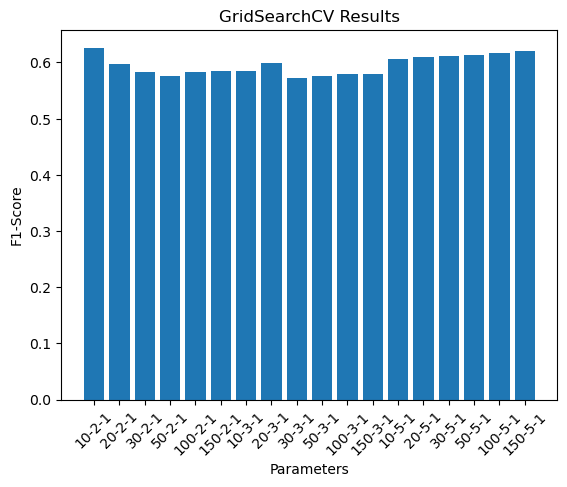

In [81]:
param_values = [f"{params['n_estimators']}-{params['max_depth']}-{params['learning_rate']}"
                for params in grid_search.cv_results_['params']]

# Создание списка F1-оценок для оси y
f1_scores = grid_search.cv_results_['mean_test_score']

# Создание графика
plt.bar(param_values, f1_scores)
plt.xlabel('Parameters')
plt.ylabel('F1-Score')
plt.title('GridSearchCV Results')
plt.xticks(rotation=45)
plt.show()

#### С помощью GridSearchCV параметры оказались хуже чем при дефолтных настройках. Обучим модель CatBoost по глубже, и посмотрим на остальные метрики

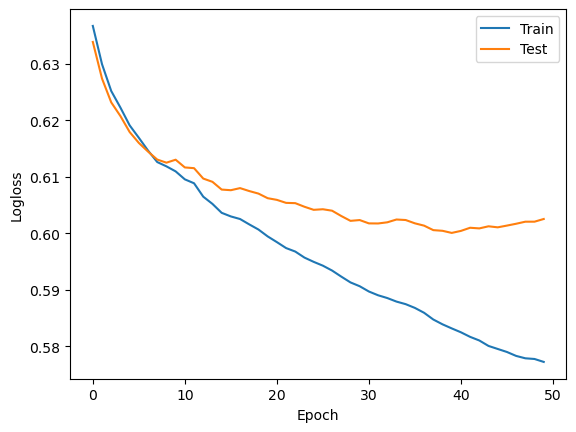

In [54]:
catboost_model = CatBoostClassifier(cat_features=categorical_columns,
                                   learning_rate=1, #1
                                   random_state = 1,
                                   max_depth=10, #6
                                   n_estimators=50, # 
                                   ) 


catboost_model.fit(X_train, y_train, cat_features=categorical_columns, eval_set=(X_test, y_test), verbose=False)

train_loss = catboost_model.evals_result_['learn']['Logloss']
test_loss = catboost_model.evals_result_['validation']['Logloss']

plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Logloss')
plt.legend()
plt.show()

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test, catboost_model.predict(X_test)).ravel()

print(f'True Negative errors: {tn}') 
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}') 
print(f'True Positive errors: {tp}') 
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred))

True Negative errors: 68443
False Positive errors: 36868
False Negative errors: 30132
True Positive errors: 64557
              precision    recall  f1-score   support

           0       0.69      0.65      0.67    105311
           1       0.64      0.68      0.66     94689

    accuracy                           0.67    200000
   macro avg       0.67      0.67      0.66    200000
weighted avg       0.67      0.67      0.67    200000



#### Модель имеет примерно одинаковую производительность для обоих классов, и средневзвешенная F1-мера составляет 0.66, что указывает на умеренную точность и полноту модели.

#### Посмотрим визуально какие фичи дали наибольший прирост модели

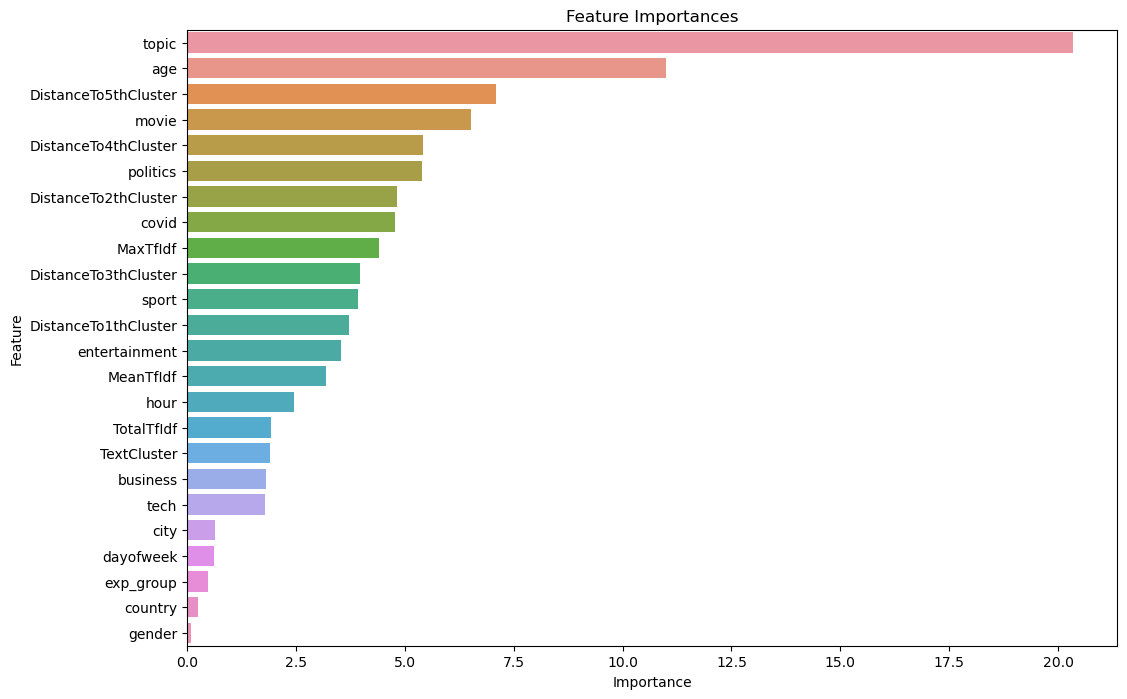

In [56]:
# Получение важностей признаков из модели
feature_importances = catboost_model.get_feature_importance()

# Создание датафрейма с важностями признаков
fi_df = pd.DataFrame({'feature': catboost_model.feature_names_, 'importance': feature_importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Вывод диаграммы с важными признаками
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Топик и предпочтения пользователей по топикам вместе с их возрастом имеют наибольшую важность в модели. Это говорит о том, что эти факторы сильно влияют на предсказание лайков пользователей. Мы подтвердили гипотезу что пользователи имеют определенные предпочтения в отношении контента, связанного с определенными темами, и их возраст также может играть роль в этом контексте.

#### Кодирование текстовых данных дало умеренную важность. Это означает, что информация, содержащаяся в текстовых полях, может быть полезной для предсказания лайков, но не является наиболее значимым фактором. Возможно, модель смогла выделить некоторые ключевые слова или фразы, связанные с популярным контентом.

#### Гендер, страна и город имеют наименьшую важность при обучении модели. Это может означать, что эти факторы слабо влияют на предсказание лайков пользователей или они не содержат достаточно информации, которая была бы значима для модели. Возможно, другие факторы, не учтенные в данной модели, более сильно связаны с предпочтениями пользователей. Подтвердили еше одну гипотезу что, день недели имеет незначительное влияние на предсказание лайков пользователей.

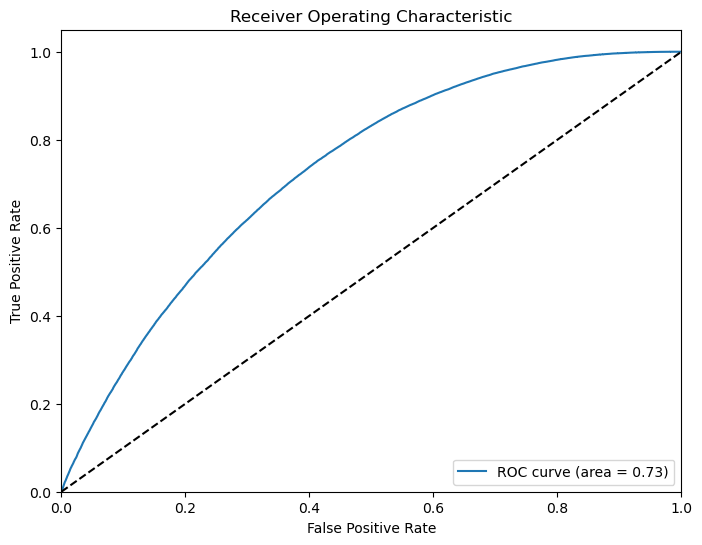

In [57]:
y_pred_proba = catboost_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [58]:
print(f"Train ROC-AUC score: {roc_auc_score(y_train, catboost_model.predict_proba(X_train)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])}")

Train ROC-AUC score: 0.7478709675228685
Test ROC-AUC score: 0.7292890626117441


####  Площадь под ROC-кривой (AUC-ROC, Area Under the ROC Curve) является метрикой, которая представляет собой численное значение, отражающее качество классификации модели. AUC-ROC имеет значение от 0 до 1, где 0.5 соответствует случайному классификатору, а значение ближе к 1 указывает на лучшую производительность модели. Модель не переобучилась.

In [99]:
catboost_model.save_model('model_control',
                        format="cbm")

#### У нас нет возможно проверить нашу контрольную метрику hitrate@5 в ноутбуке, при загрузке в чекер на сайте результат составил 0.52 при минимальном пороге 0.4, считаю достаточно хорошим результатом.

### Обучение второй модели на эмбедингах текстов наших постов с помощью предобученных моделей Hugging Face

#### Загрузка признаков

In [77]:
posts_info = pd.read_sql("""SELECT * FROM ryabgri_post_inf_features_emb_3""", con=engine)
posts_info = posts_info.drop(['index'], axis=1)
posts_info = posts_info.drop(['text'], axis=1)
print(posts_info.shape)
posts_info.head(1)

(7023, 17)


,post_id,topic,DistanceCluster_label_0,DistanceCluster_label_1,DistanceCluster_label_2,DistanceCluster_label_3,DistanceCluster_label_4,DistanceCluster_label_5,DistanceCluster_label_6,DistanceCluster_label_7,DistanceCluster_label_8,DistanceCluster_label_9,DistanceCluster_label_10,DistanceCluster_label_11,DistanceCluster_label_12,DistanceCluster_label_13,DistanceCluster_label_14
0,1,business,2.268082,3.562076,3.368115,3.218791,3.084227,3.3102,1.779077,3.263433,1.938579,2.527287,3.045932,3.280804,2.854076,3.464594,3.243605


In [78]:
frac =  feed_data_1.shape[0] / feed_data_0.shape[0] + 0.01
feed_data_0_lim = feed_data_0.sample(frac=frac)
feed_data_0_lim.shape

(506996, 4)

In [79]:
feed_data = pd.concat([feed_data_0_lim, feed_data_1])
feed_data['target'].value_counts(normalize = True)

0    0.523427
1    0.476573
Name: target, dtype: float64

In [ ]:
feed_data = feed_data.sort_values("timestamp")
feed_data = feed_data[:2_000_000]
feed_data.head(3)

,timestamp,user_id,post_id,target
23,2021-10-01 06:01:40,156604,573,1
20,2021-10-01 06:01:40,142997,6445,1
4,2021-10-01 06:01:40,66609,3270,1


In [80]:
df_2 = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')
df_2.head(2)

,timestamp,user_id,post_id,target,topic,DistanceCluster_label_0,DistanceCluster_label_1,DistanceCluster_label_2,DistanceCluster_label_3,DistanceCluster_label_4,DistanceCluster_label_5,DistanceCluster_label_6,DistanceCluster_label_7,DistanceCluster_label_8,DistanceCluster_label_9,DistanceCluster_label_10,DistanceCluster_label_11,DistanceCluster_label_12,DistanceCluster_label_13,DistanceCluster_label_14
0,2021-10-02 18:22:54,166484,5556,0,movie,2.529155,2.230199,3.141802,1.852251,2.862145,2.163220,2.978099,1.913496,2.744836,2.198535,2.993052,1.724846,3.048845,3.119382,1.658458
1,2021-10-05 13:28:09,157674,7283,0,movie,2.787498,2.407326,3.109870,1.555866,3.050462,2.073374,3.167798,1.009648,3.048906,2.304354,2.836951,1.213788,3.126611,2.817918,1.874836


In [81]:
df_2= pd.merge(df_2,
              user_info_data,
              on='user_id',
              how='left')
df_2.head(2)

,timestamp,user_id,post_id,target,topic,DistanceCluster_label_0,DistanceCluster_label_1,DistanceCluster_label_2,DistanceCluster_label_3,DistanceCluster_label_4,...,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,2021-10-02 18:22:54,166484,5556,0,movie,2.529155,2.230199,3.141802,1.852251,2.862145,...,Russia,Moscow,3,0.096774,0.096491,0.210526,0.137255,0.279070,0.250000,0.080000
1,2021-10-05 13:28:09,157674,7283,0,movie,2.787498,2.407326,3.109870,1.555866,3.050462,...,Russia,Moscow,1,0.093750,0.257485,0.179487,0.142384,0.115385,0.247525,0.071429


In [82]:
#Не будем учитывать день недели 
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])
df_2['hour'] = df_2['timestamp'].dt.hour
df_2.head(2)

,timestamp,user_id,post_id,target,topic,DistanceCluster_label_0,DistanceCluster_label_1,DistanceCluster_label_2,DistanceCluster_label_3,DistanceCluster_label_4,...,city,exp_group,business,covid,entertainment,movie,politics,sport,tech,hour
0,2021-10-02 18:22:54,166484,5556,0,movie,2.529155,2.230199,3.141802,1.852251,2.862145,...,Moscow,3,0.096774,0.096491,0.210526,0.137255,0.279070,0.250000,0.080000,18
1,2021-10-05 13:28:09,157674,7283,0,movie,2.787498,2.407326,3.109870,1.555866,3.050462,...,Moscow,1,0.093750,0.257485,0.179487,0.142384,0.115385,0.247525,0.071429,13


In [83]:
df_2= df_2.set_index(['user_id', 'post_id'])
df_2.head(5)

,,timestamp,target,topic,DistanceCluster_label_0,DistanceCluster_label_1,DistanceCluster_label_2,DistanceCluster_label_3,DistanceCluster_label_4,DistanceCluster_label_5,DistanceCluster_label_6,...,city,exp_group,business,covid,entertainment,movie,politics,sport,tech,hour
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
166484,5556,2021-10-02 18:22:54,0,movie,2.529155,2.230199,3.141802,1.852251,2.862145,2.163220,2.978099,...,Moscow,3,0.096774,0.096491,0.210526,0.137255,0.279070,0.250000,0.080000,18
157674,7283,2021-10-05 13:28:09,0,movie,2.787498,2.407326,3.109870,1.555866,3.050462,2.073374,3.167798,...,Moscow,1,0.093750,0.257485,0.179487,0.142384,0.115385,0.247525,0.071429,13
152266,5175,2021-10-06 13:46:45,0,movie,2.640359,2.391170,2.887500,1.635807,2.790717,1.872730,3.141495,...,Baranavichy,3,0.200000,0.225275,0.181818,0.202952,0.230769,0.319149,0.156250,13
76071,1900,2021-10-05 09:10:35,0,sport,3.057858,3.638123,3.752581,3.008651,2.347331,3.405394,2.617124,...,Yalova,0,0.281250,0.215827,0.266667,0.292453,0.109091,0.212500,0.097561,9
137448,6203,2021-10-04 13:20:33,0,movie,2.539298,2.526730,2.957498,1.447566,2.831635,2.137075,2.964437,...,Naberezhnyye Chelny,3,0.000000,0.031915,0.000000,0.027322,0.048780,0.102041,0.000000,13


##### Вторую модель на эмбеднгах мы будем дольше обучать и придётся отказаться от предпочтений пользователей, так как на них модель переобучается и меньше внимания уделяет на другие фичи.

In [84]:
df_2 = df_2.drop(['business', 'covid', 'entertainment', 'politics', 'movie', 'sport', 'tech'], axis = 1) 

In [85]:
df_train_2 = df_2[df_2.timestamp < '2021-10-06']
df_test_2 = df_2[df_2.timestamp >= '2021-10-06']

df_train_2 = df_train_2.drop('timestamp', axis=1)
df_test_2 = df_test_2.drop('timestamp', axis=1)

X_train_2 = df_train_2.drop('target', axis=1)
X_test_2 = df_test_2.drop('target', axis=1)

y_train_2 = df_train_2['target']
y_test_2 = df_test_2['target']

y_train_2.shape, y_test_2.shape

((740423,), (228185,))

In [86]:
y_test_2.value_counts()

0    119990
1    108195
Name: target, dtype: int64

In [87]:
categorical_columns = ['country', 'city','topic','hour','gender','country', 'city']

In [88]:

catboost = CatBoostClassifier(
    iterations=500, 
    learning_rate=1,
    depth=5, #3
    random_seed=3,
    
)
catboost.fit(X_train_2, y_train_2, categorical_columns)

from sklearn.metrics import roc_auc_score
print(f"Качество на трейне: {roc_auc_score(y_train_2, catboost.predict_proba(X_train_2)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test_2, catboost.predict_proba(X_test_2)[:, 1])}")

catboost.save_model(
    'model_test_',
    format="cbm"                  
    )


0:	learn: 0.6605998	total: 581ms	remaining: 4m 49s
1:	learn: 0.6566418	total: 1.21s	remaining: 5m 1s
2:	learn: 0.6547925	total: 1.62s	remaining: 4m 28s
3:	learn: 0.6432413	total: 2.2s	remaining: 4m 32s
4:	learn: 0.6396446	total: 2.89s	remaining: 4m 45s
5:	learn: 0.6384387	total: 3.31s	remaining: 4m 32s
6:	learn: 0.6368352	total: 3.84s	remaining: 4m 30s
7:	learn: 0.6361203	total: 4.31s	remaining: 4m 24s
8:	learn: 0.6352235	total: 4.86s	remaining: 4m 25s
9:	learn: 0.6347835	total: 5.22s	remaining: 4m 16s
10:	learn: 0.6342807	total: 5.8s	remaining: 4m 18s
11:	learn: 0.6338419	total: 6.52s	remaining: 4m 25s
12:	learn: 0.6330866	total: 7.08s	remaining: 4m 25s
13:	learn: 0.6323985	total: 7.73s	remaining: 4m 28s
14:	learn: 0.6318580	total: 8.6s	remaining: 4m 37s
15:	learn: 0.6312772	total: 9.38s	remaining: 4m 43s
16:	learn: 0.6309322	total: 9.93s	remaining: 4m 42s
17:	learn: 0.6307725	total: 10.3s	remaining: 4m 35s
18:	learn: 0.6303081	total: 10.9s	remaining: 4m 34s
19:	learn: 0.6299499	total

In [89]:
tn, fp, fn, tp = confusion_matrix(y_test_2, catboost.predict(X_test_2)).ravel()

print(f'True Negative errors: {tn}') 
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}') 
print(f'True Positive errors: {tp}') 
y_pred = catboost.predict(X_test_2)
print(classification_report(y_test_2, y_pred))

True Negative errors: 79595
False Positive errors: 40395
False Negative errors: 36799
True Positive errors: 71396
              precision    recall  f1-score   support

           0       0.68      0.66      0.67    119990
           1       0.64      0.66      0.65    108195

    accuracy                           0.66    228185
   macro avg       0.66      0.66      0.66    228185
weighted avg       0.66      0.66      0.66    228185



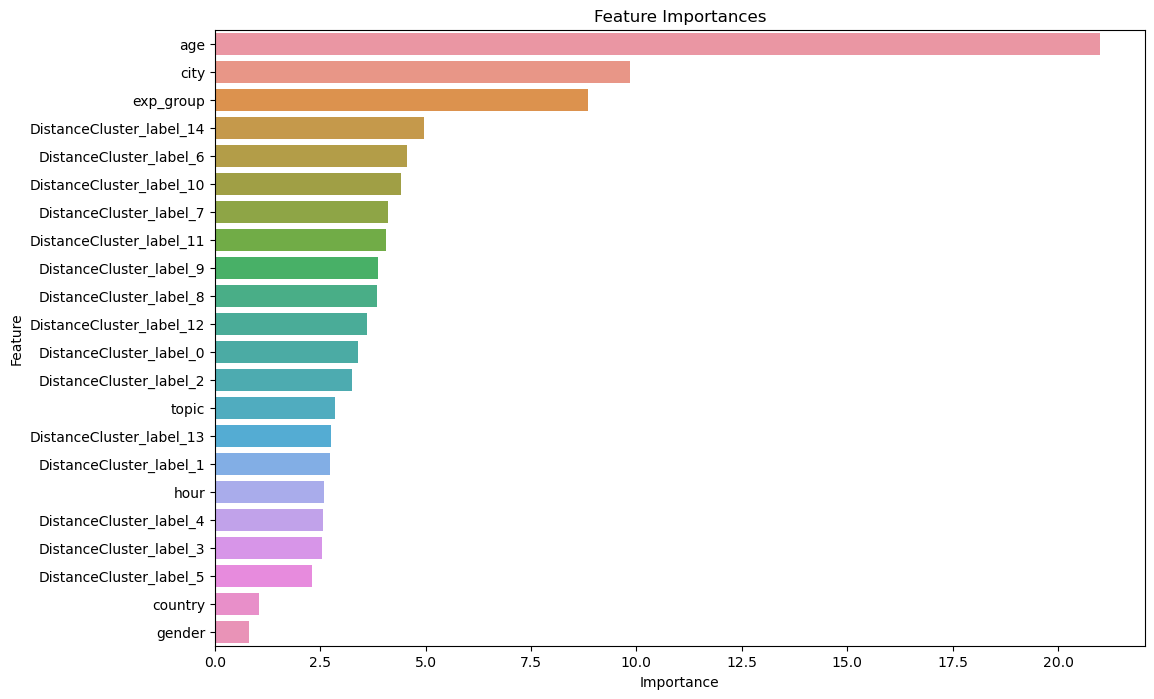

In [90]:
# Получение важностей признаков из модели
feature_importances = catboost.get_feature_importance()

# Создание датафрейма с важностями признаков
fi_df = pd.DataFrame({'feature': catboost.feature_names_, 'importance': feature_importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Вывод диаграммы с важными признаками
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

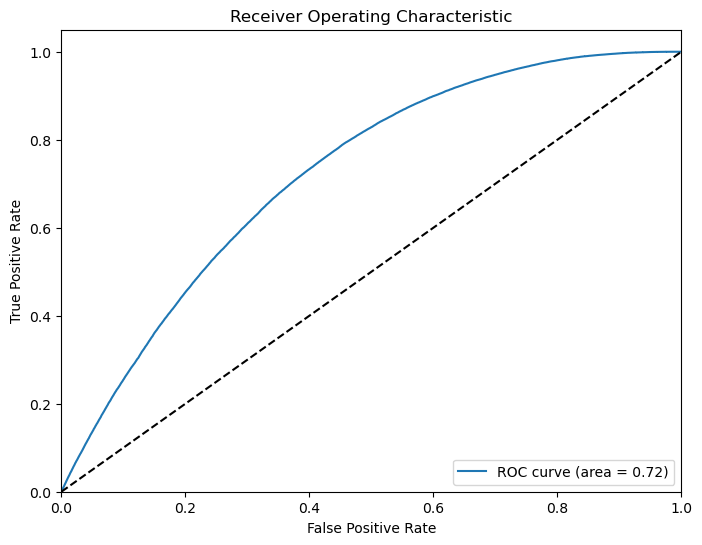

In [94]:
y_pred_proba = catboost.predict_proba(X_test_2)[:,1]
roc_auc = roc_auc_score(y_test_2, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Прокси - метрика показала практически такой же результат что модель обученная с помощью TF-IDF. Контрольная метрика hitrate@5 при загрузке в чекер на сайте показала результат 0.572. Проведем А/Б тест для проверки гипотезы о равенстве двух моделей.